# Task 4: Portfolio Optimization Based on Forecasts
We'll use the forecasts from Task 3 along with historical data to optimize the portfolio allocation.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from src.portfolio_optimization import PortfolioOptimizer
from src.market_forecasting import MarketForecaster

## 1. Load Historical Data

In [2]:
# Define symbols and date range
symbols = ['TSLA', 'BND', 'SPY']
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365*2)).strftime('%Y-%m-%d')  # 2 years of data

# Download historical data
data = PortfolioOptimizer.download_data(symbols, start_date, end_date)

# Display the first few rows
print("Data shape:", data.shape)
data.head()

Data shape: (500, 3)


,TSLA,BND,SPY
Date,,,
2023-03-06 00:00:00-05:00,193.809998,66.906120,393.368805
2023-03-07 00:00:00-05:00,187.710007,66.831482,387.338959
2023-03-08 00:00:00-05:00,182.000000,66.775482,387.971130
2023-03-09 00:00:00-05:00,172.919998,66.999435,380.813110
2023-03-10 00:00:00-05:00,173.440002,67.801811,375.318176


## 2. Calculate Asset Metrics

In [3]:
# Initialize portfolio optimizer
optimizer = PortfolioOptimizer(data)

# Calculate individual asset metrics
asset_metrics = optimizer.calculate_asset_metrics()
print("\nAsset Metrics:")
print(asset_metrics)

# Calculate Value at Risk
var = optimizer.calculate_var(confidence_level=0.95)
print("\nValue at Risk (95% confidence):")
for asset, value in var.items():
    print(f"{asset}: ${value:,.2f}")


Asset Metrics:
      Annual Return  Annual Volatility  Sharpe Ratio
TSLA       0.355747           0.572801      0.586148
BND        0.050165           0.062311      0.484102
SPY        0.207377           0.126089      1.486073

Value at Risk (95% confidence):
TSLA: $14.22
BND: $0.46
SPY: $8.09


## 3. Analyze Asset Correlations

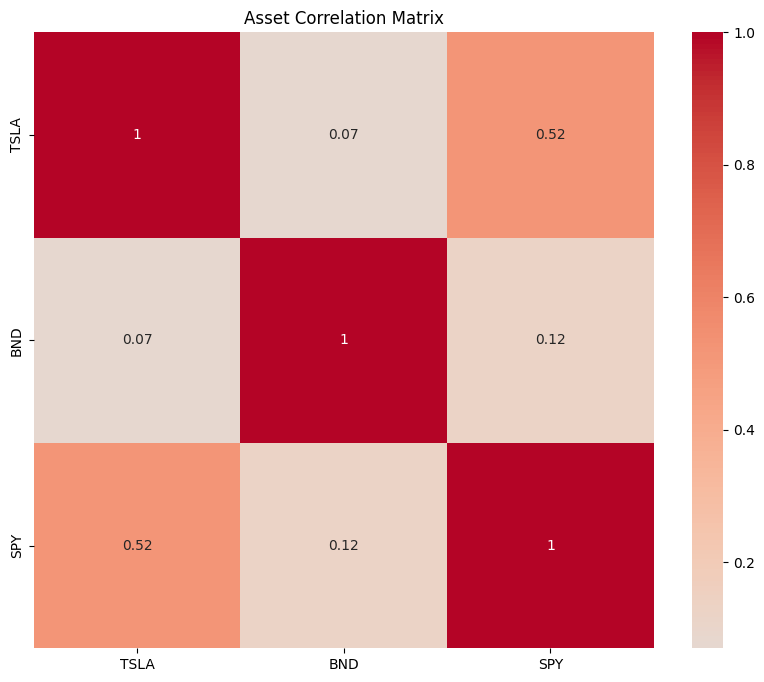

In [4]:
# Calculate and plot correlation matrix
correlation_matrix = optimizer.returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Asset Correlation Matrix')
plt.show()

## 4. Portfolio Optimization

In [5]:
# Optimize portfolio for different objectives
objectives = ['sharpe', 'return', 'risk']
results = {}

for objective in objectives:
    weights, metrics = optimizer.optimize_portfolio(objective)
    results[objective] = {
        'weights': dict(zip(symbols, weights)),
        'metrics': metrics
    }
    
    print(f"\nOptimal Portfolio ({objective.capitalize()} Optimization):")
    print("Weights:")
    for symbol, weight in zip(symbols, weights):
        print(f"{symbol}: {weight:.2%}")
    print("\nMetrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")


Optimal Portfolio (Sharpe Optimization):
Weights:
TSLA: 0.00%
BND: 30.32%
SPY: 69.68%

Metrics:
Return: 0.1597
Volatility: 0.0920
Sharpe Ratio: 1.5180

Optimal Portfolio (Return Optimization):
Weights:
TSLA: 100.00%
BND: 0.00%
SPY: 0.00%

Metrics:
Return: 0.3557
Volatility: 0.5728
Sharpe Ratio: 0.5861

Optimal Portfolio (Risk Optimization):
Weights:
TSLA: 0.00%
BND: 83.51%
SPY: 16.49%

Metrics:
Return: 0.0761
Volatility: 0.0583
Sharpe Ratio: 0.9623


## 5. Visualize Efficient Frontier

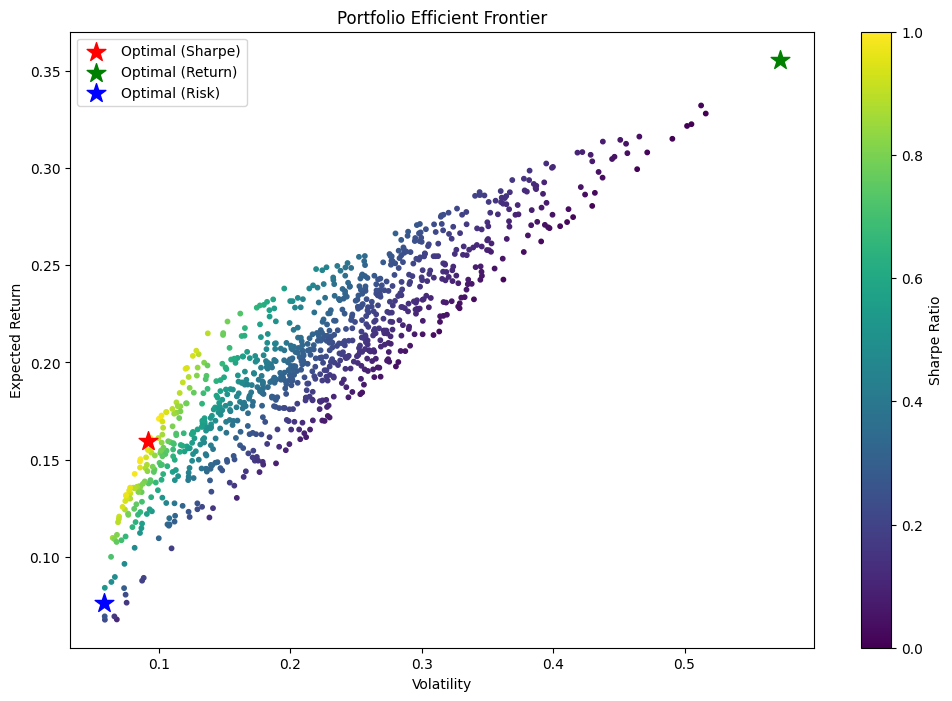

In [6]:
# Generate random portfolios
n_portfolios = 1000
returns = []
volatilities = []
sharpe_ratios = []

for _ in range(n_portfolios):
    weights = np.random.random(len(symbols))
    weights = weights / np.sum(weights)
    
    metrics = optimizer.calculate_portfolio_metrics(weights)
    returns.append(metrics['return'])
    volatilities.append(metrics['volatility'])
    sharpe_ratios.append(metrics['sharpe_ratio'])

# Plot efficient frontier
plt.figure(figsize=(12, 8))
plt.scatter(volatilities, returns, c=sharpe_ratios, cmap='viridis', marker='o', s=10)

# Plot optimal portfolios
colors = {'sharpe': 'red', 'return': 'green', 'risk': 'blue'}
for objective, result in results.items():
    plt.scatter(
        result['metrics']['volatility'],
        result['metrics']['return'],
        color=colors[objective],
        marker='*',
        s=200,
        label=f'Optimal ({objective.capitalize()})'
    )

plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Portfolio Efficient Frontier')
plt.legend()
plt.show()

## 6. Analyze Portfolio Performance

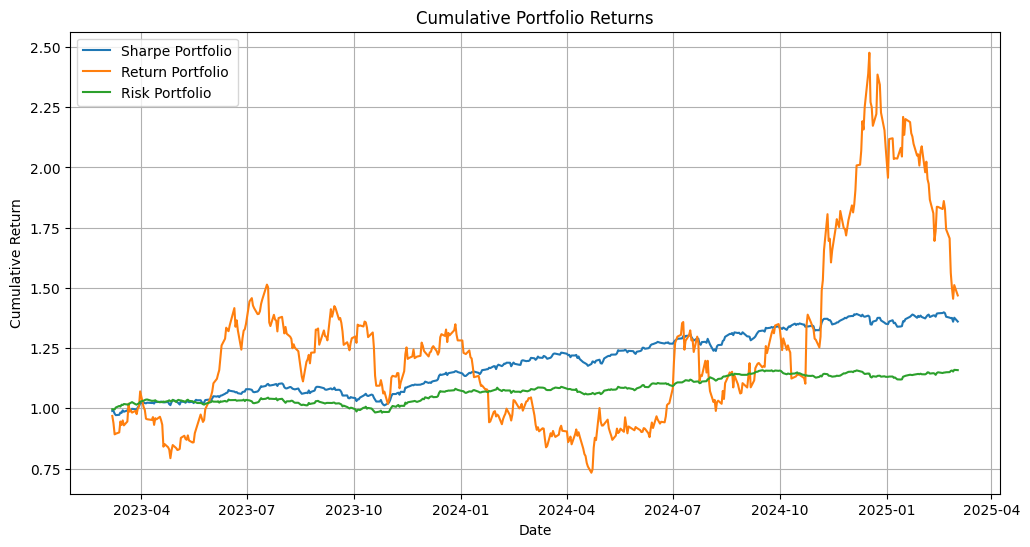

In [7]:
# Calculate cumulative returns for each optimized portfolio
plt.figure(figsize=(12, 6))

for objective, result in results.items():
    cumulative_returns = optimizer.calculate_cumulative_returns(list(result['weights'].values()))
    plt.plot(cumulative_returns.index, cumulative_returns, label=f'{objective.capitalize()} Portfolio')

plt.title('Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()